# Sampling

We have a class imbalance problem in our dataset where most reviews are 5-stars and 1-stars which leads to model bias wanted to classify reviews into one of these two categories.

In this notebook, we will use various sampling techniques to see if we can improve our model performance.

Model we will use here logistic regression with sample_weight set to 'balanced' (LRB) since this performed the best in our previous notebook. 

Since Decision Tree with class_weight set to 'balanced' (DTB) did fairly well in the last notebook, we will also run that here.

The same dataset will be used for all models - unigram TF-IDF with max features of 10k.

We will re-run this model using the same dataset as a baseline for this notebook to compare.

Count of number of examples in each class after sampling was saved to a csv file so we can load them here and look at results.

Again, metric we are using is a harmonic mean between recall of minority classes and precision of majority class

### Sampling Techniques

Over Sampling:
* Random Over Sampling - randomly oversample minority classes by duplicating minority samples
* Synthetic Minority Oversampling Technique (SMOTE) - oversampling technique where new minority examples are synthesized based on nearest neighbors of minority classes
* Adaptive Synthetic (ADAYN) - sythetically generates samples for minority class based on minority samples are wrongly classified

Under Sampling
* Random Under Sampling - undersampling technique to randomly remove majority class samples until our classes are balanced
* NEARMISS-2 - undersampling technique where majority class samples that are near minority classes are removed to create a more distinct border between majority and minority classes

# Result

Over sampling and undersampling had little effect on logistic regression. 

However, under sampling increased our performance for balanced decision tree by around 5%. However, because under sampling give us a resulting dataset of 12k samples (~4 % of our original size). With few training examples, I have concerns about whether this would generalizing well.

Our best results for decision tree, logistic regression is still performing at around 10% better.

In the futures, if we use under sampling, we would need to start with a bigger dataset. If we want 50k samples, would need to start with 1.25 million samples which seem impractical given my computing contraints

```
50k * 0.04 = 1.25mil
```



In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import importlib
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import util.model_util as mu
import util.report_util as ru
from datetime import datetime

pd.set_option('max_colwidth', 150)
%matplotlib inline
sns.set()

CONFIG_DIR = "../config"
CONFIG_FILE = f'{CONFIG_DIR}/2019-11-01-run_classifiers-sampling.csv'
REPORT_DIR = "../reports"
REPORT_FILE = f'{REPORT_DIR}/2019-11-01-run_classifiers-sampling-report.csv'
DATA_FILE = f'../dataset/feature_files/review_body-tfidf-df_default-ngram11-49784-10000-nolda.csv'

/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Running Our model

To run the models again, execute this in the *tools* directory

```
python run_classifiers.py ../config/2019-11-01-run_classifiers-sampling.csv 
```

Configuration file is listed below

In [2]:
config = pd.read_csv(CONFIG_FILE).drop(["status", "status_date", "message"], axis=1)
config

,data_dir,data_file,class_column,dtype,drop_columns,model_name,sampling
0,../dataset/feature_files,review_body-tfidf-df_default-ngram11-49784-10000-nolda.csv,star_rating,NaN,"helpful_votes, total_votes, helpful_product",LRB,adasyn
1,../dataset/feature_files,review_body-tfidf-df_default-ngram11-49784-10000-nolda.csv,star_rating,NaN,"helpful_votes, total_votes, helpful_product",DTB,adasyn
2,../dataset/feature_files,review_body-tfidf-df_default-ngram11-49784-10000-nolda.csv,star_rating,NaN,"helpful_votes, total_votes, helpful_product",LRB,random_over_sampling
3,../dataset/feature_files,review_body-tfidf-df_default-ngram11-49784-10000-nolda.csv,star_rating,NaN,"helpful_votes, total_votes, helpful_product",DTB,random_over_sampling


# Sampling Distribution

Before we look at results, let's look at the original distribution of of samples

In [3]:
data = pd.read_csv(f'{config.head(1).data_dir.values[0]}/{config.head(1).data_file.values[0]}')

In [4]:
grouped_count = data[["star_rating", "helpful_product"]].groupby("star_rating").count()
grouped_count

,helpful_product
star_rating,
1,6939
2,3226
3,4669
4,8410
5,26540


In [5]:
grouped_count = grouped_count.rename({"helpful_product": "original"}, axis=1)

In [6]:
def plot_distribution(name: str, data: pd.DataFrame):
    f, a = plt.subplots(1, 1, figsize=(20, 5))
    grouped_count.plot(kind='bar', ax=a, alpha=0.5)

    _ = data.plot(kind='bar', ax=a, color='orange', alpha=0.5)

## Over Sampling

### Random Over Sampling

Random over sampling duplicates minority samples to create new features

In [7]:
ros = pd.read_csv('../reports/review_body-tfidf-df_default-ngram11-49784-10000-nolda-histogram-random_over_sampling.csv')
ros = ros.set_index('star_rating').rename({"index": "Random Over Sampling"}, axis=1)
ros

,Random Over Sampling
star_rating,
1,19905
2,19905
3,19905
4,19905
5,19905


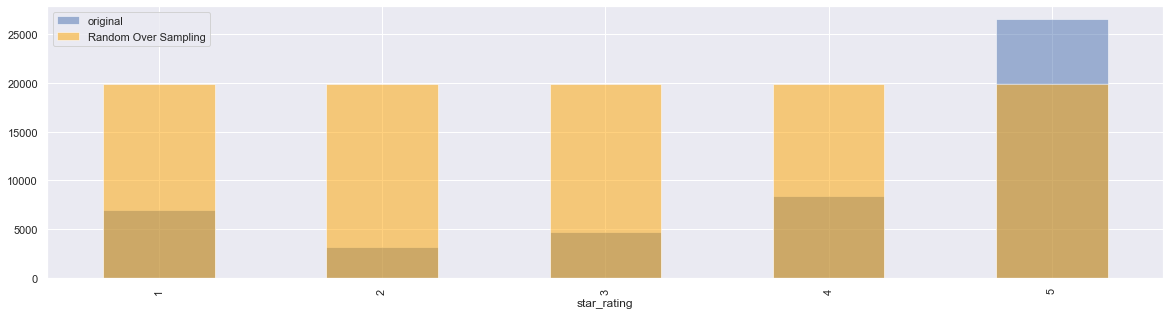

In [8]:
plot_distribution("Random Over Sampling", ros)

### SMOTE

Since SMOTE over samples the minority class. The resulting distribution gives us about 20k per class resulting is near 100k samples in our dataset

In [9]:
smote = pd.read_csv('../reports/review_body-tfidf-df_default-ngram11-49784-10000-nolda-histogram-smote.csv')
smote = smote.set_index('star_rating').rename({"index": "SMOTE"}, axis=1)
smote

,SMOTE
star_rating,
1,19905
2,19905
3,19905
4,19905
5,19905


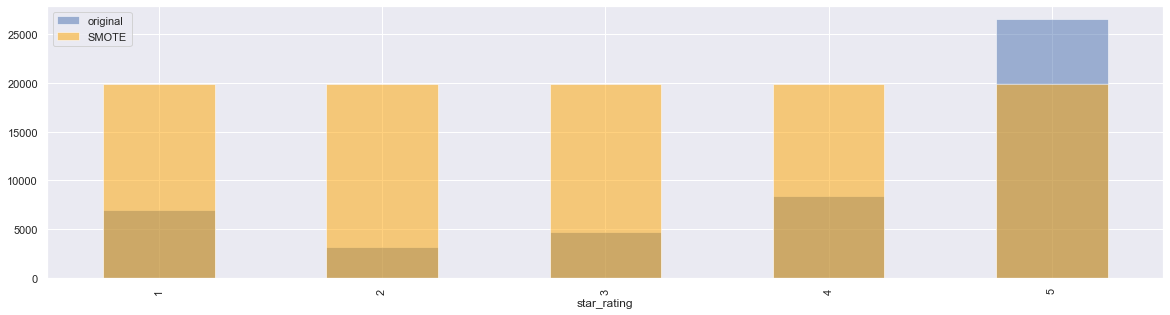

In [10]:
plot_distribution("SMOTE", smote)

### Adaptive Synthetic (ADASYN)

Since SMOTE over samples the minority class. The resulting distribution gives us about 20k per class resulting is near 100k samples in our dataset

In [11]:
adasyn = pd.read_csv('../reports/review_body-tfidf-df_default-ngram11-49784-10000-nolda-histogram-adasyn.csv')
adasyn = adasyn.set_index('star_rating').rename({"index": "ADASYN"}, axis=1)
adasyn

,ADASYN
star_rating,
1,21181
2,19075
3,19213
4,21301
5,19905


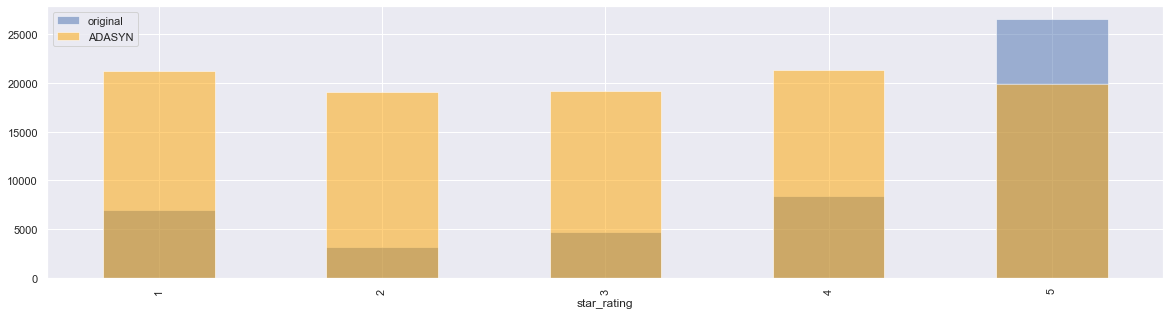

In [12]:
plot_distribution("Adaptive Synthetic", adasyn)

## Undersampling
### Random Undersampling

Our sample distribution is even after under sampling. However, because we only had about 2500 Star-2 reviews to begin with, this reduced all classes to only have around 2500 entires giving us only 12k samples to train with

In [13]:
rus = pd.read_csv('../reports/review_body-tfidf-df_default-ngram11-49784-10000-nolda-histogram-random_under_sampling.csv')
rus = rus.set_index("star_rating").rename({"index": "Random Under Sampling"}, axis=1)
rus

,Random Under Sampling
star_rating,
1,2420
2,2420
3,2420
4,2420
5,2420


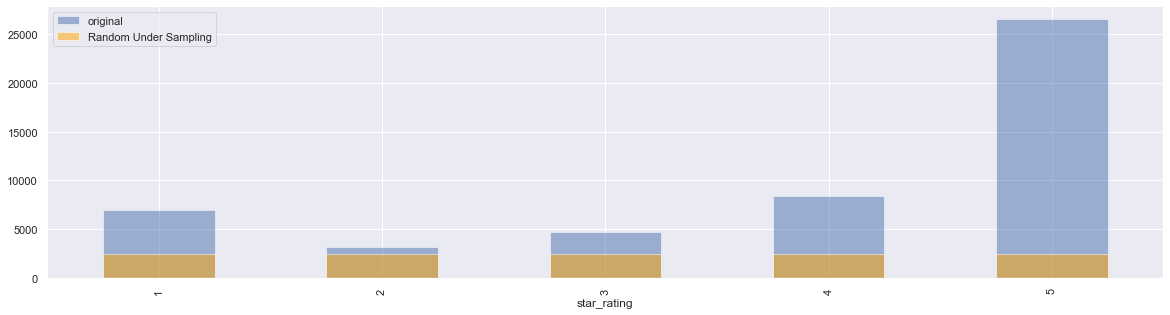

In [14]:
plot_distribution("Random Under Sampling", rus)

### Nearmiss-2

Again, nearmiss reduced our dataset to be about 12k because there were only about 2500 samples in the 2-star class

In [15]:
nearmiss = pd.read_csv('../reports/review_body-tfidf-df_default-ngram11-49784-10000-nolda-histogram-nearmiss-2.csv')
nearmiss = nearmiss.set_index('star_rating').rename({"index": "Nearmiss"}, axis=1)
nearmiss

,Nearmiss
star_rating,
1,2420
2,2420
3,2420
4,2420
5,2420


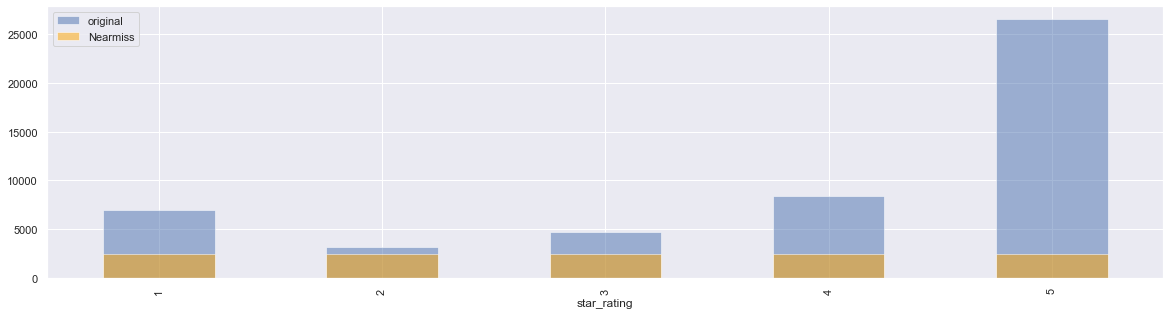

In [16]:
plot_distribution("Nearmiss", nearmiss)

# Results

Over sampling and under-sampling actually did not do as well as no sampling at all for Logistic Regression

For Decision Tree - oversampling with SMOTE did .5% worse and under sampling did about 5% better than no sampling

In [17]:
report = ru.load_report(REPORT_FILE)

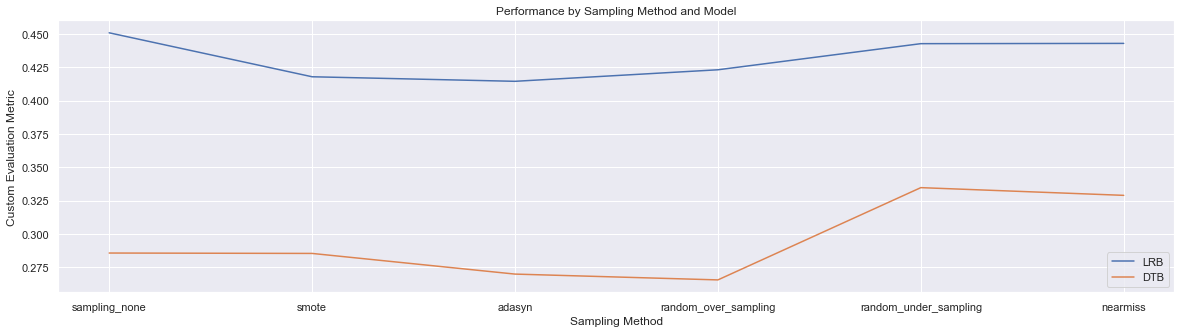

In [18]:
f, a = plt.subplots(1, 1, figsize=(20, 5))
for model in report.model_name.unique():
    sns.lineplot(data=report[report.model_name == model], 
                 x="sampling_str", y='eval_metric', label=model, sort=False)
_ = plt.title("Performance by Sampling Method and Model")
_ = plt.ylabel("Custom Evaluation Metric")
_ = plt.xlabel("Sampling Method")

In [19]:
report[["model_name", "sampling_str", "eval_metric"]].sort_values("model_name")

,model_name,sampling_str,eval_metric
1,DTB,sampling_none,0.285760
3,DTB,smote,0.285460
5,DTB,adasyn,0.269978
7,DTB,random_over_sampling,0.265625
9,DTB,random_under_sampling,0.334764
11,DTB,nearmiss,0.328984
0,LRB,sampling_none,0.450793
2,LRB,smote,0.417853
4,LRB,adasyn,0.414445
6,LRB,random_over_sampling,0.423086


In [20]:
import json

print(report[(report.model_name == 'DTB') &
                              (report.sampling_str == 'random_under_sampling')].confusion_matrix.values[0])

[[687, 561, 209, 135, 143], [215, 253, 158, 93, 87], [159, 318, 275, 232, 183], [182, 366, 363, 572, 620], [435, 651, 712, 1444, 3393]]


In [21]:
cols = ["model_name", "eval_metric"]
cols.extend([col for col in report.columns if re.search("(precision|recall)", col)])
best2 = report[((report.model_name == 'DTB') | (report.model_name == 'LRB')) &
                              (report.sampling_str == 'random_under_sampling')][cols]

In [22]:
best2

,model_name,eval_metric,1_precision,1_recall,2_precision,2_recall,3_precision,3_recall,4_precision,4_recall,5_precision,5_recall,macro avg_precision,macro avg_recall,weighted avg_precision,weighted avg_recall
8,LRB,0.442658,0.610458,0.598847,0.191789,0.388337,0.233818,0.303342,0.311357,0.388493,0.847608,0.635418,0.439006,0.462888,0.623915,0.541459
9,DTB,0.334764,0.409416,0.395965,0.117729,0.313896,0.160163,0.235647,0.231018,0.271992,0.766606,0.511379,0.336986,0.345776,0.527431,0.416198


# Plot in 2D

To save time, we will randomly sample 4k entries

In [23]:
importlib.reload(mu)

samples = data.sample(5000)
X_train, X_test, Y_train, Y_test = mu.create_training_data(samples,
                                                            "star_rating", 
                                                            "helpful_votes, total_votes, helpful_product")

In [24]:
from sklearn.decomposition import PCA

print(X_train.shape)
pca = PCA(n_components=2)
x2d = pd.DataFrame(pca.fit_transform(X_train)).rename({"0": "x", "1": "y"})

(3750, 10000)


In [25]:
y = Y_train.reset_index(drop=True)
# print(x2d.head())
# print(y.head())

x1 = x2d[y == 1]
x2 = x2d[y == 2]
x3 = x2d[y == 3]
x4 = x2d[y == 4]
x5 = x2d[y == 5]

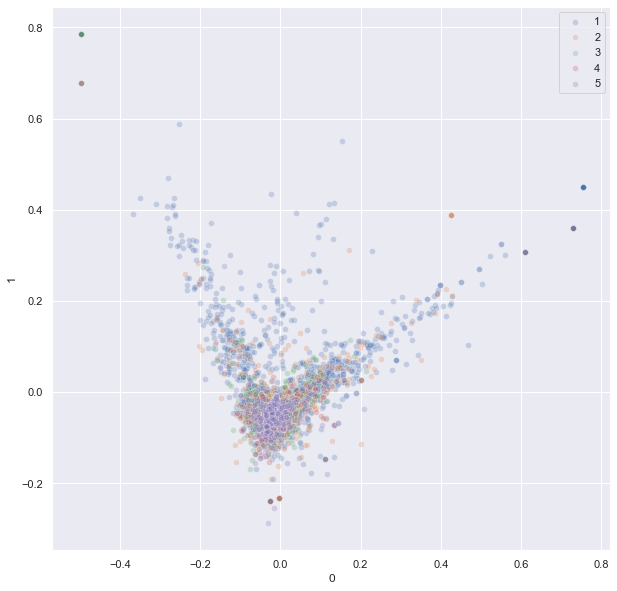

In [26]:
f, a = plt.subplots(1, 1, figsize=(10, 10))
rating = 1
# plot in reverse order so we can see overlap better
for x in [x5, x4, x3, x2, x1]:
    sns.scatterplot(x=x[:][0], y=x[:][1], ax=a, label=rating, alpha=0.25)
    rating += 1

# Plot in 3D

Reduct to 3D using PCA

In [27]:

x3d_train, x3d_test, y3d_train, y3d_test = mu.create_training_data(samples,
                                                            "star_rating", 
                                                            "helpful_votes, total_votes, helpful_product")
y3d = y3d_train.reset_index(drop=True)

pca3d = PCA(n_components=3)
x3d = pd.DataFrame(pca3d.fit_transform(X_train)).rename({0: "x", 1: "y", 2: "z"}, axis=1)
x1_3d = x3d[y3d == 1]
x2_3d = x3d[y3d == 2]
x3_3d = x3d[y3d == 3]
x4_3d = x3d[y3d == 4]
x5_3d = x3d[y3d == 5]

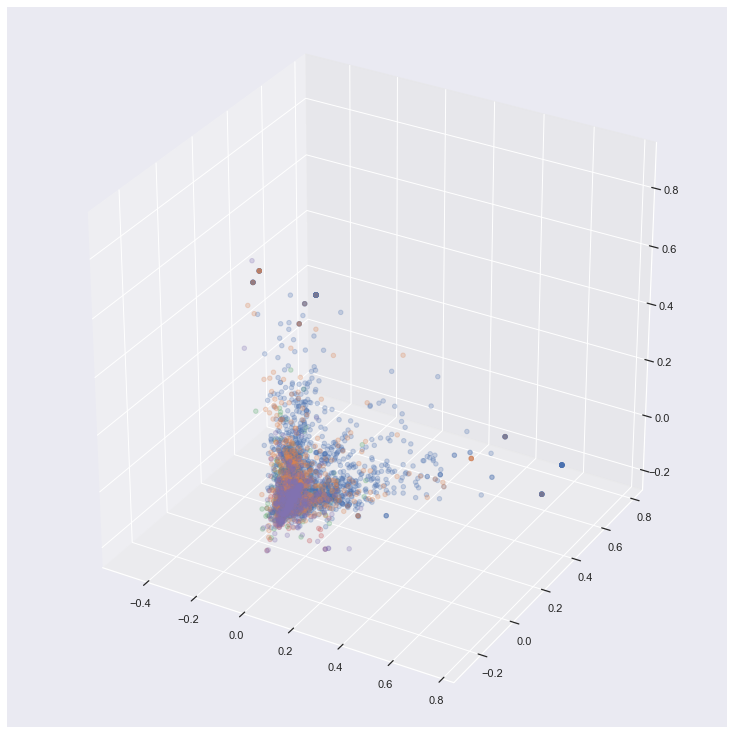

In [28]:
from mpl_toolkits.mplot3d import Axes3D


f = plt.figure(figsize=(10, 10))
a = Axes3D(f)

rating = 1
# plot in reverse order so we can see overlap better
for x in [x5_3d, x4_3d, x3_3d, x2_3d, x1_3d]:
    a.scatter(x["x"], x["y"], x["z"], label=rating, alpha=0.25)
    rating += 1

